In [1]:
from processing import monophony
from processing.monophony import *
from models import transformer_encoder_decoder
from models import *

Using TensorFlow backend


In [2]:
monophony._group_subdirs_contents(from_dir='lpd_5/lpd_5_full', to_dir='lpd_5/all')

Total Tracks:  174154


'lpd_5/all'

In [2]:
model = transformer_encoder_decoder(ignore_last_class=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, None, 100)            13400     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, None, 100)            13400     ['input_2[0][0]']         

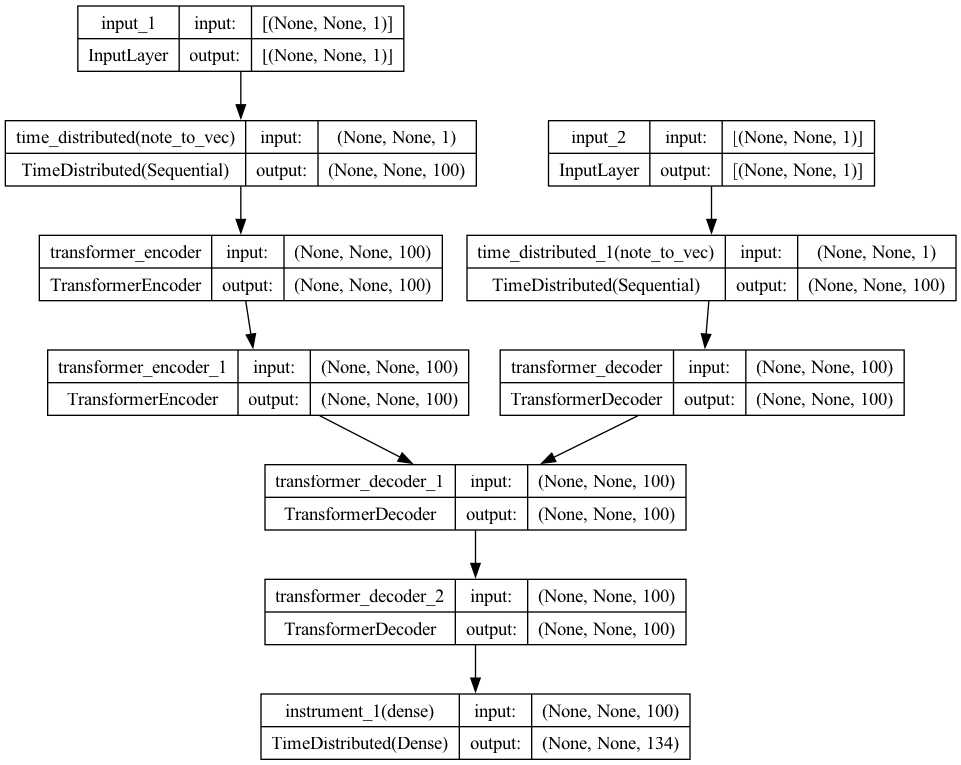

In [3]:
plot_model(model, show_layer_names=True, show_shapes=True)

In [4]:
#output_sequence_len = 0 if not encoder_decoder else >=1

# Data INFO
# ~175K midi files
# Files could be short melodies, loop compositions or long symphonies or songs
# ~10K midi files in each of the 16 top level subdirectories 
# Considering 300 midi files at present, at 8 resolution..~ 0.2% Dataset
# Generating a polyphonic monophony music (multiple instruments each following a monophonic melody line independently) or type of contrapuntal 
train_source, val_source, test_source  = sample_dataset('./lpd_5/all', nsamples=10000, train_size=0.9, val_size=0.2, input_sequence_len=100, output_sequence_len=200, resolution=8, prune_rest_note_percent=0.5, batch_size=128, encoder_decoder=True)

Preparing test dataset...: 100%|██████████| 1000/1000 [00:53<00:00, 18.69it/s]


In [5]:
train_source = ('lpd_5_batched/train_inputs', 'lpd_5_batched/train_outputs')
music_loader = load_music_batches(*train_source, encoder_decoder=True)
steps = len(os.listdir(train_source[0]))-1
steps

9909

In [6]:
val_source = ('lpd_5_batched/val_inputs', 'lpd_5_batched/val_outputs')
val_music_loader = load_music_batches(*val_source, encoder_decoder=True)
val_steps = len(os.listdir(val_source[0]))-1
val_steps

2532

In [7]:
import tensorflow as tf
import os


class ModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, model, checkpoint_dir, save_best_only=True):
        super(ModelCheckpoint, self).__init__()
        self.model = model
        self.checkpoint_dir = checkpoint_dir
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if self.save_best_only and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            filepath = os.path.join(self.checkpoint_dir, f"best_model")
            self.model.save(filepath)
            print(f"Saved model to {filepath} (val_loss: {val_loss:.4f})")
        else:
            filepath = os.path.join(self.checkpoint_dir, f"model_epoch_{epoch}")
            self.model.save(filepath)
            print(f"Saved model to {filepath} (val_loss: {val_loss:.4f})")

modelname = "encoder-decoder-transformer-10Ksamples-1instrument-longer"
checkpoint_dir = f"./{modelname}-checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
model_checkpoint = ModelCheckpoint(model, checkpoint_dir)
callbacks_list = [model_checkpoint]   


In [ ]:
history = model.fit(music_loader, steps_per_epoch=steps, validation_data=val_music_loader, validation_steps=val_steps, epochs=3, callbacks=callbacks_list)

In [7]:
model.save(modelname)

INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer/assets


INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer/assets


In [9]:
tracks = sample_track('lpd_5/all', nsamples=100, input_sequence_len=100, resolution=8)

Sampling tracks...: 100%|██████████| 100/100 [00:01<00:00, 58.52it/s]


In [10]:
x, y = tracks[randint(0, len(tracks)-1)]
composer = compose_music(music_model=model, cue=x, topn=129, encoder_decoder=True, print_gen=True)



In [10]:
x.shape, y.shape

((100, 1), (1861, 1))

In [14]:

os.makedirs('./generations_set_mono', exist_ok=True)
os.makedirs('./validation_set_mono', exist_ok=True)

for i in range(15):
    print(f"Sample : {i+1}")
    try:
        x, y = tracks[randint(0, len(tracks)-1)]
        composer = compose_music(music_model=model, cue=x, topn=129, encoder_decoder=True, print_gen=False)
        total_track_length = y.shape[0]
        composition_length = int(0.5*total_track_length)
        TEMPO = 60

        print(f"Composing for {composition_length} time steps at {TEMPO} bpm")
        for _ in range(composition_length):
            composition = next(composer)
         
        print("Composition Done...")


        output_midi_path = f'./generations_set_mono/generated_track_transformer_{i}.mid'
        output_audio_path = f'./generations_set_mono/generated_track_transformer_{i}.wav'

        
        
        generated_track = make_track(composition, tempo=TEMPO)
        print("Track Done...")

        multitrack_to_midi(generated_track, output_midi_path)
        print("Generated Midi file Done...")

        midi_to_wav(output_midi_path, output_audio_path)
        print("Generated Audio file Done...")



        output_midi_path = f'./validation_set_mono/original_track_transformer_{i}.mid'
        output_audio_path = f'./validation_set_mono/original_track_transformer_{i}.wav'



        original_track = make_track(composition=y[:composition_length], tempo=TEMPO, composition_tokenized=False)
        print("Original Track Done...")

        multitrack_to_midi(original_track, output_midi_path)
        print("Original Midi file Done...")
        midi_to_wav(output_midi_path, output_audio_path)
        print("Original Audio file Done...")

  
    except Exception as E:
        print(E)
        pass

Sample : 1
Composing for 1256 time steps at 60 bpm
Composition Done...
Track Done...
Generated Midi file Done...
Playing ./generations_set_mono/generated_track_transformer_0.mid
MIDI file: ./generations_set_mono/generated_track_transformer_0.mid
Format: 1  Tracks: 2  Divisions: 220
Track name: Piano
Playing time: ~161 seconds
Notes cut: 0
Notes lost totally: 0
Conversion completed successfully.
Generated Audio file Done...
Original Track Done...
Original Midi file Done...
Playing ./validation_set_mono/original_track_transformer_0.mid
MIDI file: ./validation_set_mono/original_track_transformer_0.mid
Format: 1  Tracks: 2  Divisions: 220
Track name: Piano
Playing time: ~161 seconds
Notes cut: 0
Notes lost totally: 0
Conversion completed successfully.
Original Audio file Done...
Sample : 2
Composing for 1509 time steps at 60 bpm
Composition Done...
Track Done...
Generated Midi file Done...
Playing ./generations_set_mono/generated_track_transformer_1.mid
MIDI file: ./generations_set_mono/ge

In [13]:
!rm -r ./generations_set_mono/